In [1]:
!nvidia-smi
%matplotlib inline

Mon Jul  7 11:41:54 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   31C    P0             50W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade datasets fsspec

In [ ]:
!pip install dspy

In [1]:
import os
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

import openai
import os
import time
import pandas as pd

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
# For Snellius
# For Snellius
input_csv = "../data/few_shots.csv"
df_few_shots = pd.read_csv(input_csv)
real_csv = "../data/Test_1155.csv"
df_test_1155 = pd.read_csv(real_csv)
learning_csv = "../data/in-context_learning_set.csv"
df_in_context_learning = pd.read_csv(learning_csv)

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

## Pre-processing Google NQ data (dev set for now)

In [4]:
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [5]:
dataset = load_dataset("google-research-datasets/natural_questions", "dev")["validation"]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

In [6]:
def simplify_nq_example(example):
    question = example['question']['text']

    # "Annotation" is of dict structure, and each entry is a list
    annotations = example['annotations']

    simplified_example = {
        'question': question,
        'short_answers': [],
        'long_answer': ''
    }

    # if long_answer entry exists
    long_answer_idx = next((idx for idx, la in enumerate(annotations['long_answer']) if la['start_token'] != -1), None)
    if long_answer_idx is not None:
        la = annotations['long_answer'][long_answer_idx]
        start_token, end_token = la['start_token'], la['end_token']
        simplified_example['long_answer'] = ' '.join(
            example['document']['tokens']['token'][start_token:end_token]
        )

        # the short answer
        short_answer = annotations['short_answers'][long_answer_idx]
        simplified_example['short_answers'] = short_answer['text']

    return simplified_example

def remove_html_tags(text):
    clean = re.compile(r"<.*?>")
    return re.sub(clean, "", text)

def simplify_nq_example_clean(example):
    simplified = simplify_nq_example(example)
    simplified["long_answer"] = remove_html_tags(simplified["long_answer"])
    return simplified

simplified_dataset = dataset.map(simplify_nq_example_clean, remove_columns=dataset.column_names)

In [7]:
"""
# Filtering out data points where both "long answer" and "short answer" are empty
def has_any_answer(example):
    long_ok = example["long_answer"].strip() != ""
    short_ok = len(example["short_answers"]) > 0
    return long_ok or short_ok

filtered_dataset = simplified_dataset.filter(has_any_answer)
"""

# Only keeping examples with both short and long answers
filtered_dataset = simplified_dataset.filter(
    lambda x: x["long_answer"].strip() != "" and len(x["short_answers"]) > 0
)
print(len(simplified_dataset))
print(len(filtered_dataset))
#print(len(filtered_dataset))

7830
3516


In [8]:
sampled_dataset = filtered_dataset.shuffle(seed=42).select(range(1000))

In [9]:
sampled_dataset[2]

{'question': 'when did the study of media effects begin',
 'short_answers': ['1919'],
 'long_answer': " The social impact of mass communication has been studied at The New School University in New York since its founding in 1919 . The first college course to investigate the motion picture was offered here in 1926 . Marshall McLuhan 's colleague , John Culkin , brought his Center for Understanding Media to The New School in 1975 and The New School began offering the Master of Arts degree in Media Studies , one of the first graduate programs of its kind . Today , among other programs , MA in Media Studies is still being offered by School of Media Studies , The New School , which will celebrate 40th anniversary of Media Studies at The New School during the academic year 2015 - 2016 "}

In [10]:
sampled_dataset.to_json("GoogleNQ_sample.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1721553

## Inputting questions into the DSPy Classifier

#### Loading a model

In [11]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
         api_base="http://localhost:7501/v1",
         api_key="whatever", model_type='chat',
         cache=False,
         temperature=0.0,
         max_tokens=5000)
dspy.configure(lm=model)

#### Helper functions

In [12]:
def run_batch(batch, class_to_use):
    results = []
    for request in batch["question"]:
        try:
            result = class_to_use(request=request)
            results.append({
                "category": result.category,
                "judgment": result.judgment,
                "reasoning": getattr(result, "reasoning", "")
            })
        except Exception as e:
            print(f"Error processing request '{request}': {e}")
            results.append({
                "category": "error",
                "judgment": "error",
                "reasoning": "error"
            })
    return {
        "category": [r["category"] for r in results],
        "judgment": [r["judgment"] for r in results],
        "reasoning": [r["reasoning"] for r in results]
    }



def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

def collect_thinking_streaming(loaded_model, output_path):
    history_data = loaded_model.history
    print(f'The current length of history is {len(history_data)}.')

    with open(output_path, 'w', encoding='utf-8') as f:
        for record in history_data:
            thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
            json.dump({"thinking": thinking}, f)
            f.write('\n')


def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"Length mismatch：'{column_name}' The column length is {len(values)}, but the dataset has {len(dataset)} samples.")
        dataset = dataset.add_column(column_name, values)

    return dataset

#### The DSPy classfication program from Exp 2

In [13]:
loaded_dspy_program = dspy.load("../Reproductivity/dspy_program/")
# Encapsule the loaded program into the batch running function
wrapped_batch = partial(run_batch, class_to_use=loaded_dspy_program)

In [14]:
# batch parameters
batch_size = 5
num_samples = len(sampled_dataset)
batches = [sampled_dataset.select(range(i, min(i + batch_size, num_samples))) for i in range(0, num_samples, batch_size)]

# Initialize a dict of outputs with empty lists using designated keys
all_outputs = {"category": [], "judgment": [], "reasoning": []}

# tqdm progress bar
for batch in tqdm(batches, desc="Running DSPy classification"):
    out = wrapped_batch(batch)
    for key in all_outputs:
        all_outputs[key].extend(out[key])

Running DSPy classification: 100%|██████████| 200/200 [1:59:55<00:00, 35.98s/it]  


In [15]:
# Integrate outputs into the original dataset (copy)
annotated_dataset = add_columns_to_dataset(sampled_dataset, all_outputs)

# Create the UND subset
underspecified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "underspecified"
)

# Create the FS subset
fully_specified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "fully specified"
)

# The size of subsets
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("classified_GoogleNQ_sample_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("classified_GoogleNQ_sample_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("classified_GoogleNQ_sample_FS.jsonl", orient="records", lines=True)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Underspecified samples: 300
Fully specified samples: 700


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1404817

In [16]:
annotated_dataset[0]

{'question': 'where does the modern view of history originate from',
 'short_answers': ['approximately in the early 16th century'],
 'long_answer': "  The early modern period began approximately in the early 16th century ; notable historical milestones included the European Renaissance , the Age of Discovery , and the Protestant Reformation .   The late modern period began approximately in the mid-18th century ; notable historical milestones included the French Revolution , the American Revolution , the Industrial Revolution and the Great Divergence . It took all of human history up to 1804 for the world 's population to reach 1 billion ; the next billion came just over a century later , in 1927 .   Contemporary history is the span of historic events from approximately 1945 that are immediately relevant to the present time .  ",
 'category': 'Undetermined standard or preference',
 'judgment': 'underspecified',
 'reasoning': 'The request is underspecified because the phrase “modern view

In [17]:
# Collect thinking
think_list = collect_thinking(model)
print(f"The number of thinking pieces is {len(think_list)}.")
think_df = pd.DataFrame(think_list)
think_df.to_csv('think_GoogleNQ_sample.csv')

collect_thinking_streaming(model, "think_GoogleNQ_sample.jsonl")

The current length of history is 1096.
The number of thinking pieces is 1096.
The current length of history is 1096.


In [18]:
df = pd.read_json("classified_GoogleNQ_sample_all.jsonl", lines=True)
df.to_csv('classified_GoogleNQ_sample_all.csv')
df

,question,short_answers,long_answer,category,judgment,reasoning
0,where does the modern view of history originat...,[approximately in the early 16th century],The early modern period began approximately ...,Undetermined standard or preference,underspecified,The request is underspecified because the phra...
1,when was the first book made into a movie,[1924],"In 1924 , Erich von Stroheim attempted a lite...",Undetermined standard or preference,underspecified,The request is underspecified because the term...
2,when did the study of media effects begin,[1919],The social impact of mass communication has b...,fully specified,fully specified,This question is fully specified because it as...
3,where are the giant redwoods located in califo...,"[Humboldt County, Del Norte County]",Redwood National and State Parks IUCN c...,fully specified,fully specified,This question is fully specified because it cl...
4,when did the first wireless beats come out,[October 2012],"In October 2012 , Beats unveiled its first tw...",Undetermined lexicons or references,underspecified,The request is underspecified because the term...
...,...,...,...,...,...,...
995,who is the drummer for guns and roses,[Frank Ferrer],Image Name Years active Instruments ...,fully specified,fully specified,This question is fully specified because it re...
996,where was the movie 500 days of summer filmed,[Los Angeles],David Ng of the Los Angeles Times describes a...,fully specified,fully specified,This question is fully specified because it cl...
997,what was the lowest barometric pressure for hu...,[914 mbar (hPa; 27.0 inHg)],In between Rita and Katrina is Hurricane Alle...,fully specified,fully specified,This question is fully specified because it re...
998,what is the meaning of auv in cars,[action utility vehicles],"In Australia and New Zealand , the term SUV i...",Undetermined lexicons or references,underspecified,The request is underspecified because the term...


## QA implementations

#### Loading back the classified subsets

In [2]:
underspecified_set = load_dataset(
    "json",
    data_files="classified_GoogleNQ_sample_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="classified_GoogleNQ_sample_FS.jsonl",
    split="train"
)

#### Loading an LLM for short and long QA programs

In [3]:
from openai import OpenAI

client = OpenAI(
    api_key="",
    base_url="https://api.openai.com/v1"
) # Delete when sharing

In [2]:
def ask_short_answer(question, client, model="gpt-4o-2024-11-20", temperature=0, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question with a concise response. "
        "Return answers as a list of strings. If there's only one answer, return a single-item list. "
        "Each answer should be brief and direct."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            content = response.choices[0].message.content
            if content.startswith("["):
                return eval(content)
            else:
                return [content.strip()]
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
            
    return ["[Error]: Max retries exceeded"]

def ask_long_answer(question, client, model="gpt-4o-2024-11-20", temperature=0.7, max_retries=5, sleep_time=2.0):
    system_prompt = (
        "Answer the question thoroughly and helpfully. Provide context, explanations, and relevant details "
        "from Wikipedia that would help the user understand the topic better."
    )
    retries = 0
    while retries < max_retries:
        try:
            response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": question}
                ],
                temperature=temperature
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            retries += 1
            time.sleep(sleep_time * retries)
    return "[Error]: Max retries exceeded"

### Helper functions to run QA in batches

In [5]:
def run_batch_shortQA_api(batch, client, **kwargs):
    short_answers = []
    for q in batch["question"]:
        try:
            answer = ask_short_answer(q, client=client, **kwargs)
            short_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

def run_batch_longQA_api(batch, client, **kwargs):
    long_answers = []
    for q in batch["question"]:
        try:
            answer = ask_long_answer(q, client=client, **kwargs)
            long_answers.append(answer)
        except Exception as e:
            print(f"Error: {e}")
            long_answers.append("error")
    return {"model_long_answer": long_answers}

def batch_QA_with_progress(dataset, batch_fn, output_key, batch_size=10, fill_value="error", **batch_fn_kwargs):
    all_outputs = []
    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch, **batch_fn_kwargs)
            if output_key not in output:
                raise ValueError(f"Missing key '{output_key}' in batch result")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    if len(all_outputs) != len(dataset):
        print(f"[Warning] Output length mismatch, auto-filling")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

#### Implementation

In [6]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 30/30 [03:46<00:00,  7.55s/it]


In [7]:
long_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=run_batch_longQA_api,
    output_key="model_long_answer",
    fill_value="error",
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.7
)

Running model_long_answer: 100%|██████████| 30/30 [40:50<00:00, 81.68s/it]


In [8]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_shortQA_api,
    output_key="model_short_answer",
    fill_value=["error"],
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.0
)

Running model_short_answer: 100%|██████████| 70/70 [07:12<00:00,  6.18s/it]


In [6]:
long_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=run_batch_longQA_api,
    output_key="model_long_answer",
    fill_value="error",
    client=client,
    model="gpt-4o-2024-11-20",
    temperature=0.7
)

Running model_long_answer: 100%|██████████| 70/70 [1:29:34<00:00, 76.78s/it]


In [10]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])
for key in long_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, long_results_UND[key])

qa_underspecified.to_json("GoogleNQ_UND_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1496128

In [11]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])

qa_fully_specified.to_json("GoogleNQ_FS_qa_gpt.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1455248

In [7]:
fully_specified_set = load_dataset(
    "json",
    data_files="GoogleNQ_FS_qa_gpt.jsonl",
    split="train"
)
qa_fully_specified = deepcopy(fully_specified_set)

for key in long_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, long_results_FS[key])

qa_fully_specified.to_json("GoogleNQ_FS_qa_gpt.jsonl", orient="records", lines=True)

Generating train split: 0 examples [00:00, ? examples/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3013899

In [9]:
df = pd.read_json("GoogleNQ_UND_qa_gpt.jsonl", lines=True)
df.to_csv('GoogleNQ_UND_qa_gpt.csv')

df = pd.read_json("GoogleNQ_FS_qa_gpt.jsonl", lines=True)
df.to_csv('GoogleNQ_FS_qa_gpt.csv')

In [10]:
df

,question,short_answers,long_answer,category,judgment,reasoning,model_short_answer,model_long_answer
0,when did the study of media effects begin,[1919],The social impact of mass communication has b...,fully specified,fully specified,This question is fully specified because it as...,[The study of media effects began in the early...,The study of media effects began in the early ...
1,where are the giant redwoods located in califo...,"[Humboldt County, Del Norte County]",Redwood National and State Parks IUCN c...,fully specified,fully specified,This question is fully specified because it cl...,[- Sequoia National Park \n- Redwood National...,"Giant redwoods, known as **Sequoia semperviren..."
2,this inventor co-created the film fred ott’s s...,[Edison],Fred Ott 's Sneeze Directed by Wi...,fully specified,fully specified,This question is fully specified because it re...,[William K.L. Dickson],The inventor who co-created the short film *Fr...
3,who has won the most games in nfl 2017,[Dallas Cowboys],Rank Team Won Lost Tied Pct . F...,fully specified,fully specified,This question is fully specified because it re...,[New England Patriots],"In the 2017 NFL regular season, the **Philadel..."
4,where are more than half your bones located,[the appendicular skeleton],The skeleton of an adult human consists of 20...,fully specified,fully specified,This question is fully specified because it as...,[In your hands and feet.],More than half of the bones in the human body ...
...,...,...,...,...,...,...,...,...
695,when was the last time minnesota vikings was i...,[XI],"Since the team 's first season in 1961 , the ...",fully specified,fully specified,This question is fully specified because it re...,"[January 9, 1977]",The last time the Minnesota Vikings appeared i...
696,who is the drummer for guns and roses,[Frank Ferrer],Image Name Years active Instruments ...,fully specified,fully specified,This question is fully specified because it re...,[Frank Ferrer],"The current drummer for *Guns N' Roses*, as of..."
697,where was the movie 500 days of summer filmed,[Los Angeles],David Ng of the Los Angeles Times describes a...,fully specified,fully specified,This question is fully specified because it cl...,"[Los Angeles, California]","The romantic comedy-drama *""(500) Days of Summ..."
698,what was the lowest barometric pressure for hu...,[914 mbar (hPa; 27.0 inHg)],In between Rita and Katrina is Hurricane Alle...,fully specified,fully specified,This question is fully specified because it re...,[914 mb],"Hurricane Irma, a powerful and catastrophic Ca..."


## Evaluations

In [2]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="GoogleNQ_UND_qa_gpt.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="GoogleNQ_FS_qa_gpt.jsonl",
    split="train"
)

#### Squad EM + F1

In [3]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="GoogleNQ_FS_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 29.29
F1 Score: 47.47


In [4]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="GoogleNQ_UND_qa_gpt.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 15.67
F1 Score: 30.91


In [5]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="short_answers"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [6]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("Google_NQ_UND_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1501794

In [7]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("Google_NQ_FS_qa_gpt_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3026928

In [8]:
df = pd.read_json("Google_NQ_UND_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('Google_NQ_UND_qa_gpt_with_squad_scores.csv')

df = pd.read_json("Google_NQ_FS_qa_gpt_with_squad_scores.jsonl", lines=True)
df.to_csv('Google_NQ_FS_qa_gpt_with_squad_scores.csv')

In [9]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 16.00
UND F1 Score (avg): 31.41
FS Exact Match (avg): 29.86
FS F1 Score (avg): 48.19
F1: t=6.481, p=0.0000
EM: t=5.063, p=0.0000


#### Visualization

In [10]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)

# 计算中位数
medians = df_f1.groupby("Subset")["F1"].median()

# 标注中位数数值
for i, (subset, median_val) in enumerate(medians.items()):
    ax.text(
        i, median_val + 0.03, f"{median_val:.2f}",
        ha='center', va='bottom', fontsize=11, weight='bold', color='black'
    )

plt.title("gpt-4o-2024-11-20 F1 Score Distribution by Subset - GoogleNQ")
plt.ylim(-0.05, 1.05)
plt.ylabel("F1 Score")
plt.xlabel("")
plt.tight_layout()
plt.savefig("GoogleNQ_f1_boxplot_gpt.png", dpi=300)
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("gpt-4o-2024-11-20 Exact Match Rate by Subset (± CI) - GoogleNQ")
plt.tight_layout()
plt.savefig("GoogleNQ_em_barplot_gpt.png", dpi=300)
plt.close()

/scratch-local/yhuang.13034533/ipykernel_1329648/909201545.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.13034533/ipykernel_1329648/909201545.py:33: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.13034533/ipykernel_1329648/909201545.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


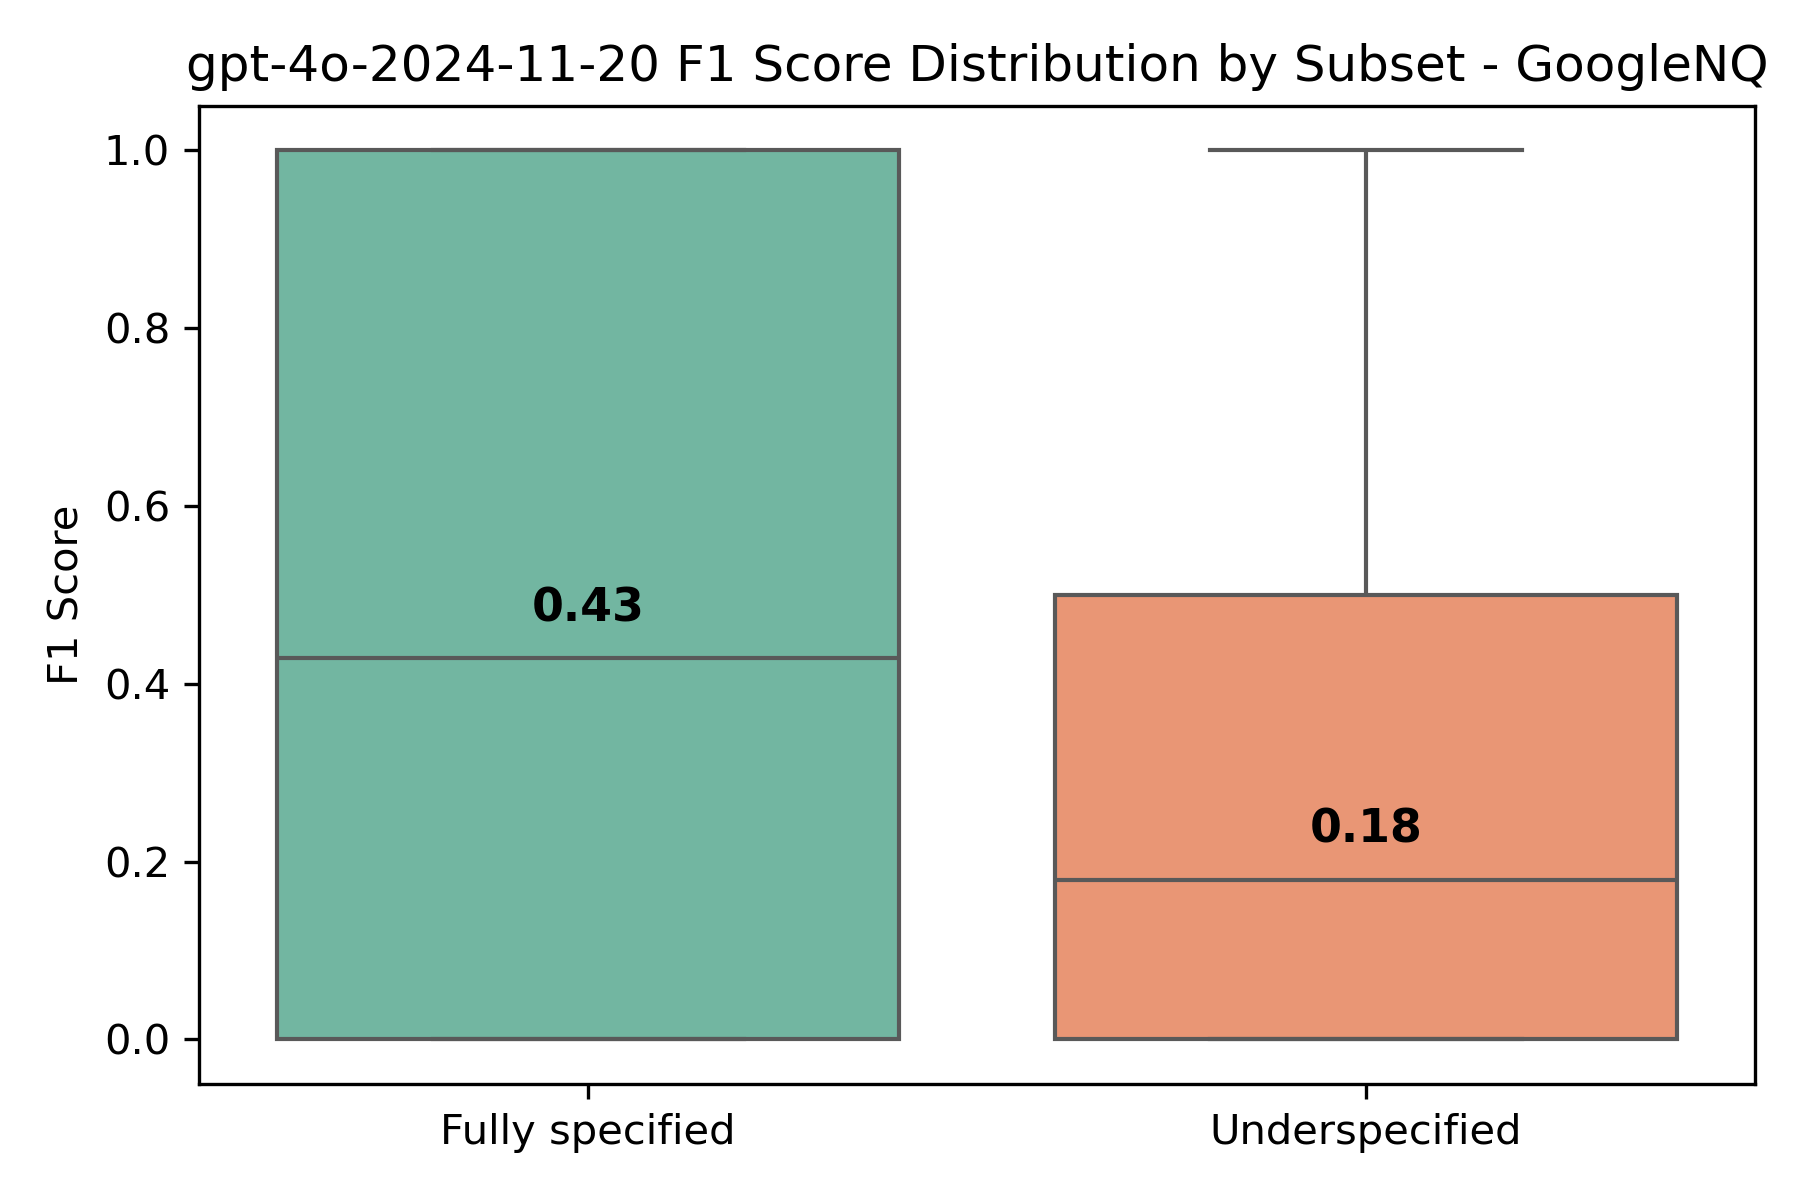

In [11]:
from IPython.display import Image
Image("GoogleNQ_f1_boxplot_gpt.png")

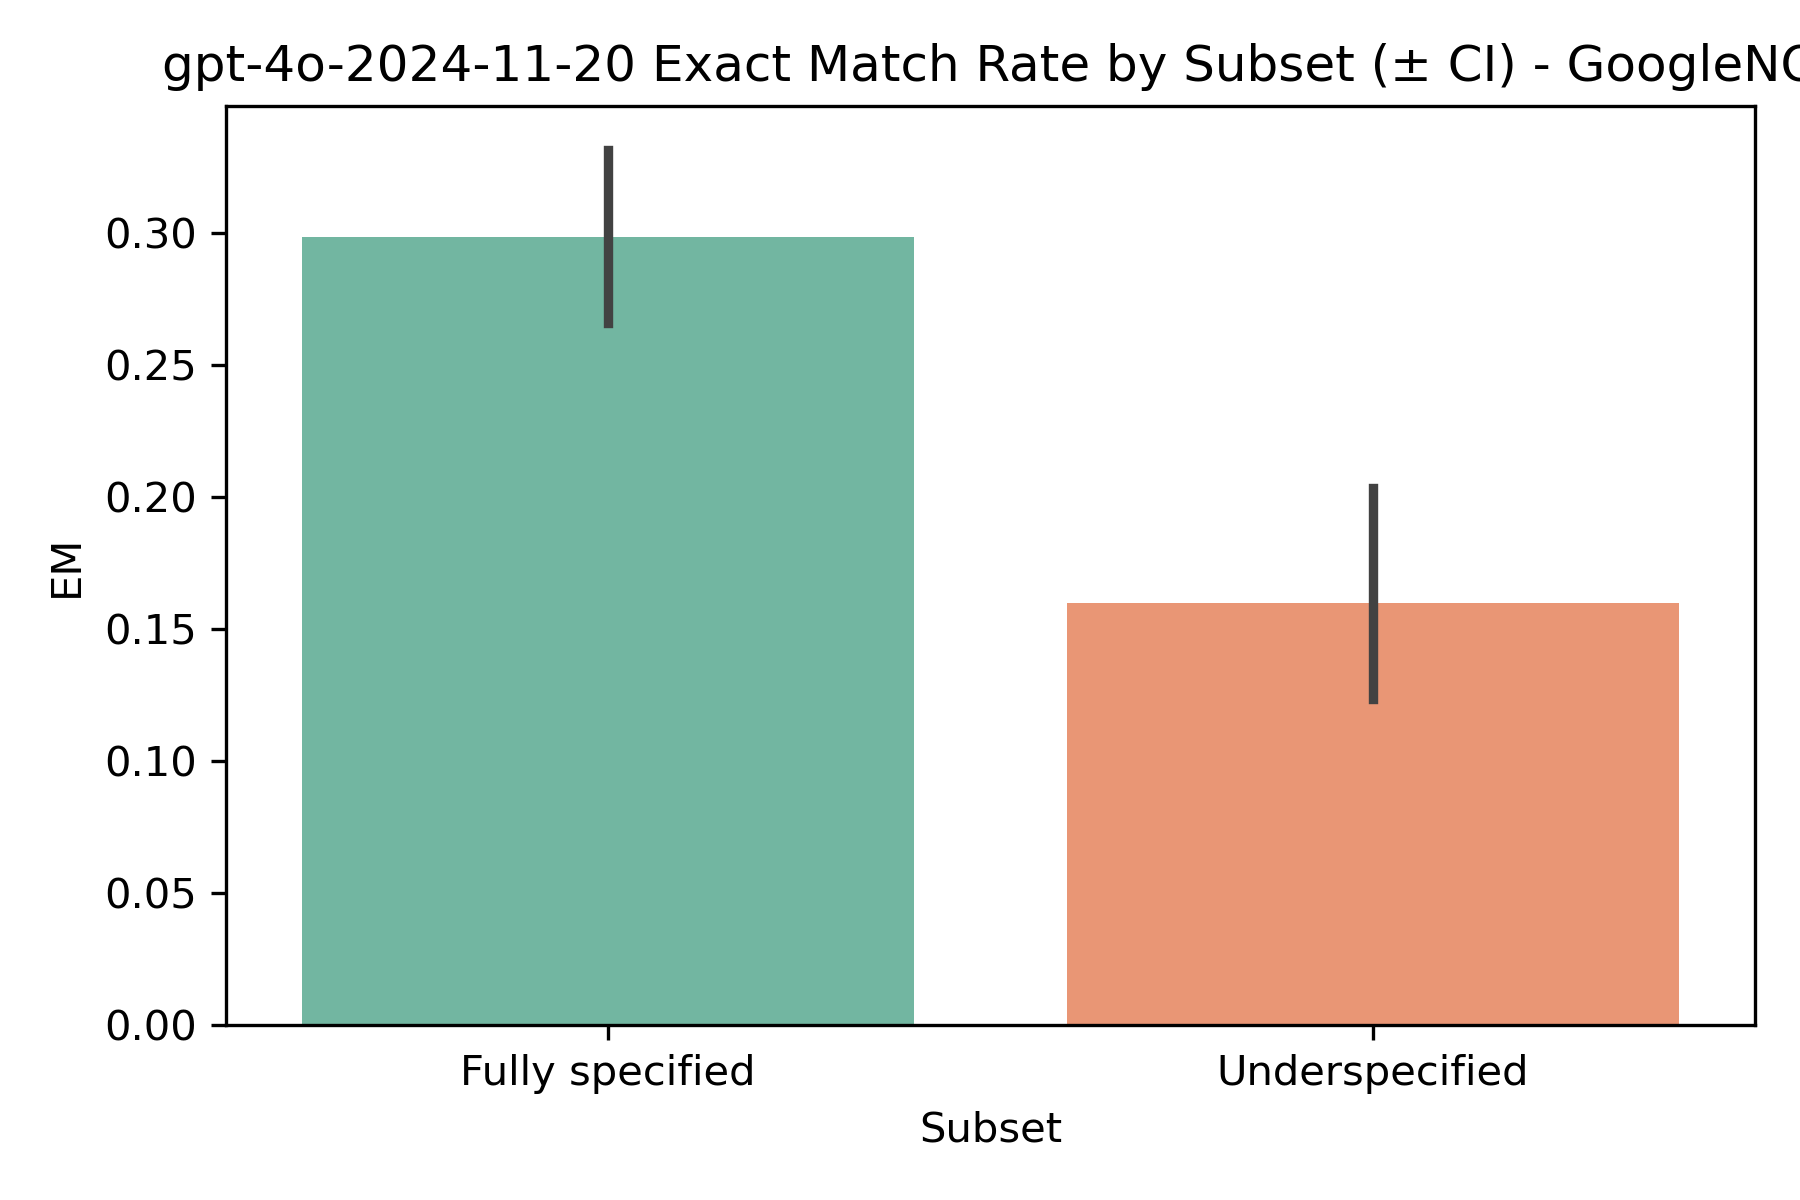

In [12]:
Image("GoogleNQ_em_barplot_gpt.png")

#### BLEU, ROUGE, METEOR, BERTScore

In [24]:
UND = load_dataset(
    "json",
    data_files="Google_NQ_UND_qa_gpt_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS = load_dataset(
    "json",
    data_files="Google_NQ_FS_qa_gpt_with_squad_scores.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [37]:
def evaluate_long_answer_all_metrics(
    dataset: Dataset,
    pred_col: str,
    ref_col: str,
    metrics: list = ["bleu", "meteor", "rouge", "bertscore"]
) -> dict:
    """
    对 dataset 中每条样本逐一计算多个文本生成评估指标。
    支持 BLEU, METEOR, ROUGE-L, BERTScore。

    Args:
        dataset: HuggingFace Dataset。
        pred_col: 模型预测列名（str）。
        ref_col: 参考答案列名（str）。
        metrics: 要计算的指标列表，支持 "bleu", "meteor", "rouge", "bertscore"。

    Returns:
        Dict[str, List[float]]: 每个指标对应一个分数列表。
    """
    metric_objects = {m: evaluate.load(m) for m in metrics}
    all_scores = {m: [] for m in metrics}

    for item in tqdm(dataset, desc="Evaluating metrics"):
        pred = item[pred_col]
        ref = item[ref_col]

        if not pred or not ref:
            for m in metrics:
                all_scores[m].append(0.0)
            continue

        for m in metrics:
            try:
                if m == "rouge":
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result["rougeL"])
                elif m == "bertscore":
                    result = metric_objects[m].compute(predictions=[pred], references=[ref], lang="en")
                    all_scores[m].append(result["f1"][0])  # 取 BERTScore F1 分数
                else:
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result[m])
            except Exception as e:
                print(f"Error scoring sample with {m}: {e}")
                all_scores[m].append(0.0)

    return all_scores

def add_scores_to_dataset(dataset, scores_dict):
    """
    将多个指标打分列表合并为 dataset 的新列。

    Args:
        dataset (Dataset): 原始 HuggingFace Dataset。
        scores_dict (dict): 如 {"bleu": [...], "meteor": [...]}，每个值都是 len=N 的分数列表。

    Returns:
        Dataset: 增加了评估分数的新数据集。
    """

    # 确保每个指标的分数长度与数据集行数一致
    for k, v in scores_dict.items():
        assert len(v) == len(dataset), f"Length mismatch for {k}: {len(v)} != {len(dataset)}"

    # 加入每个指标为新列
    new_dataset = dataset
    for k, v in scores_dict.items():
        new_dataset = new_dataset.add_column(k, v)

    return new_dataset
def t_test_metrics(scores_1: dict, scores_2: dict, label_1="Group 1", label_2="Group 2"):
    """
    对两个子集的多个指标进行 t-test，并打印结果。

    Args:
        scores_1 (dict): 子集 1 的评估分数，形式为 {"metric": [scores]}。
        scores_2 (dict): 子集 2 的评估分数，形式相同。
    """
    common_metrics = set(scores_1.keys()) & set(scores_2.keys())

    print(f"\nT-test results between {label_1} and {label_2}:\n")
    for metric in sorted(common_metrics):
        x = scores_1[metric]
        y = scores_2[metric]

        t_stat, p_val = ttest_ind(x, y, equal_var=False)
        print(f"{metric.upper():<10} | t = {t_stat:6.3f} | p = {p_val:.4f} | "
              f"{'significant' if p_val < 0.05 else 'not significant'}")

def plot_metric_distributions(scores_1, scores_2, label_1="Group 1", label_2="Group 2", filename="Google_NQ_metric_plot.png"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    # 构建 DataFrame
    rows = []
    for metric in scores_1:
        if metric in scores_2:
            for v in scores_1[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_1})
            for v in scores_2[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_2})
    df = pd.DataFrame(rows)

    # 绘图设置
    sns.set(style="whitegrid", font_scale=1.1)
    g = sns.catplot(
        data=df, kind="box", x="metric", y="score", hue="group",
        height=5, aspect=1.6, palette="Set2", showfliers=True  # Keep outliers，remove swarm
    )

    g.set_axis_labels("Metric", "Score")
    g.set_titles("Metric Score Distributions")
    g.despine(left=True)
    plt.title("gpt-4o-2024-11-20 Long Answer Evaluation Score Distributions by Group")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()

    return Image(filename)

In [26]:
scores_UND = evaluate_long_answer_all_metrics(
    dataset=UND,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

scores_FS = evaluate_long_answer_all_metrics(
    dataset=FS,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yhuang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating metrics:   0%|          | 0/300 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating metrics: 100%|██████████| 300/300 [30:32<00:00,  6.11s/it]
[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab 

In [27]:
# 合并
UND_with_most_metrics = add_scores_to_dataset(UND, scores_UND)
FS_with_most_metrics = add_scores_to_dataset(FS, scores_FS)

# 保存为新 jsonl（可选）
UND_with_most_metrics.to_json("GoogleNQ_UND_gpt_with_most_metrics.jsonl")
FS_with_most_metrics.to_json("GoogleNQ_FS_gpt_with_most_metrics.jsonl")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

3085891

In [31]:
t_test_metrics(scores_FS, scores_UND, label_1="UND", label_2="FS")


T-test results between UND and FS:

BERTSCORE  | t =  3.140 | p = 0.0018 | significant
BLEU       | t =  3.060 | p = 0.0023 | significant
METEOR     | t =  3.983 | p = 0.0001 | significant
ROUGE      | t =  3.678 | p = 0.0003 | significant


/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/scratch-local/yhuang.13017567/ipykernel_2568354/2232327884.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


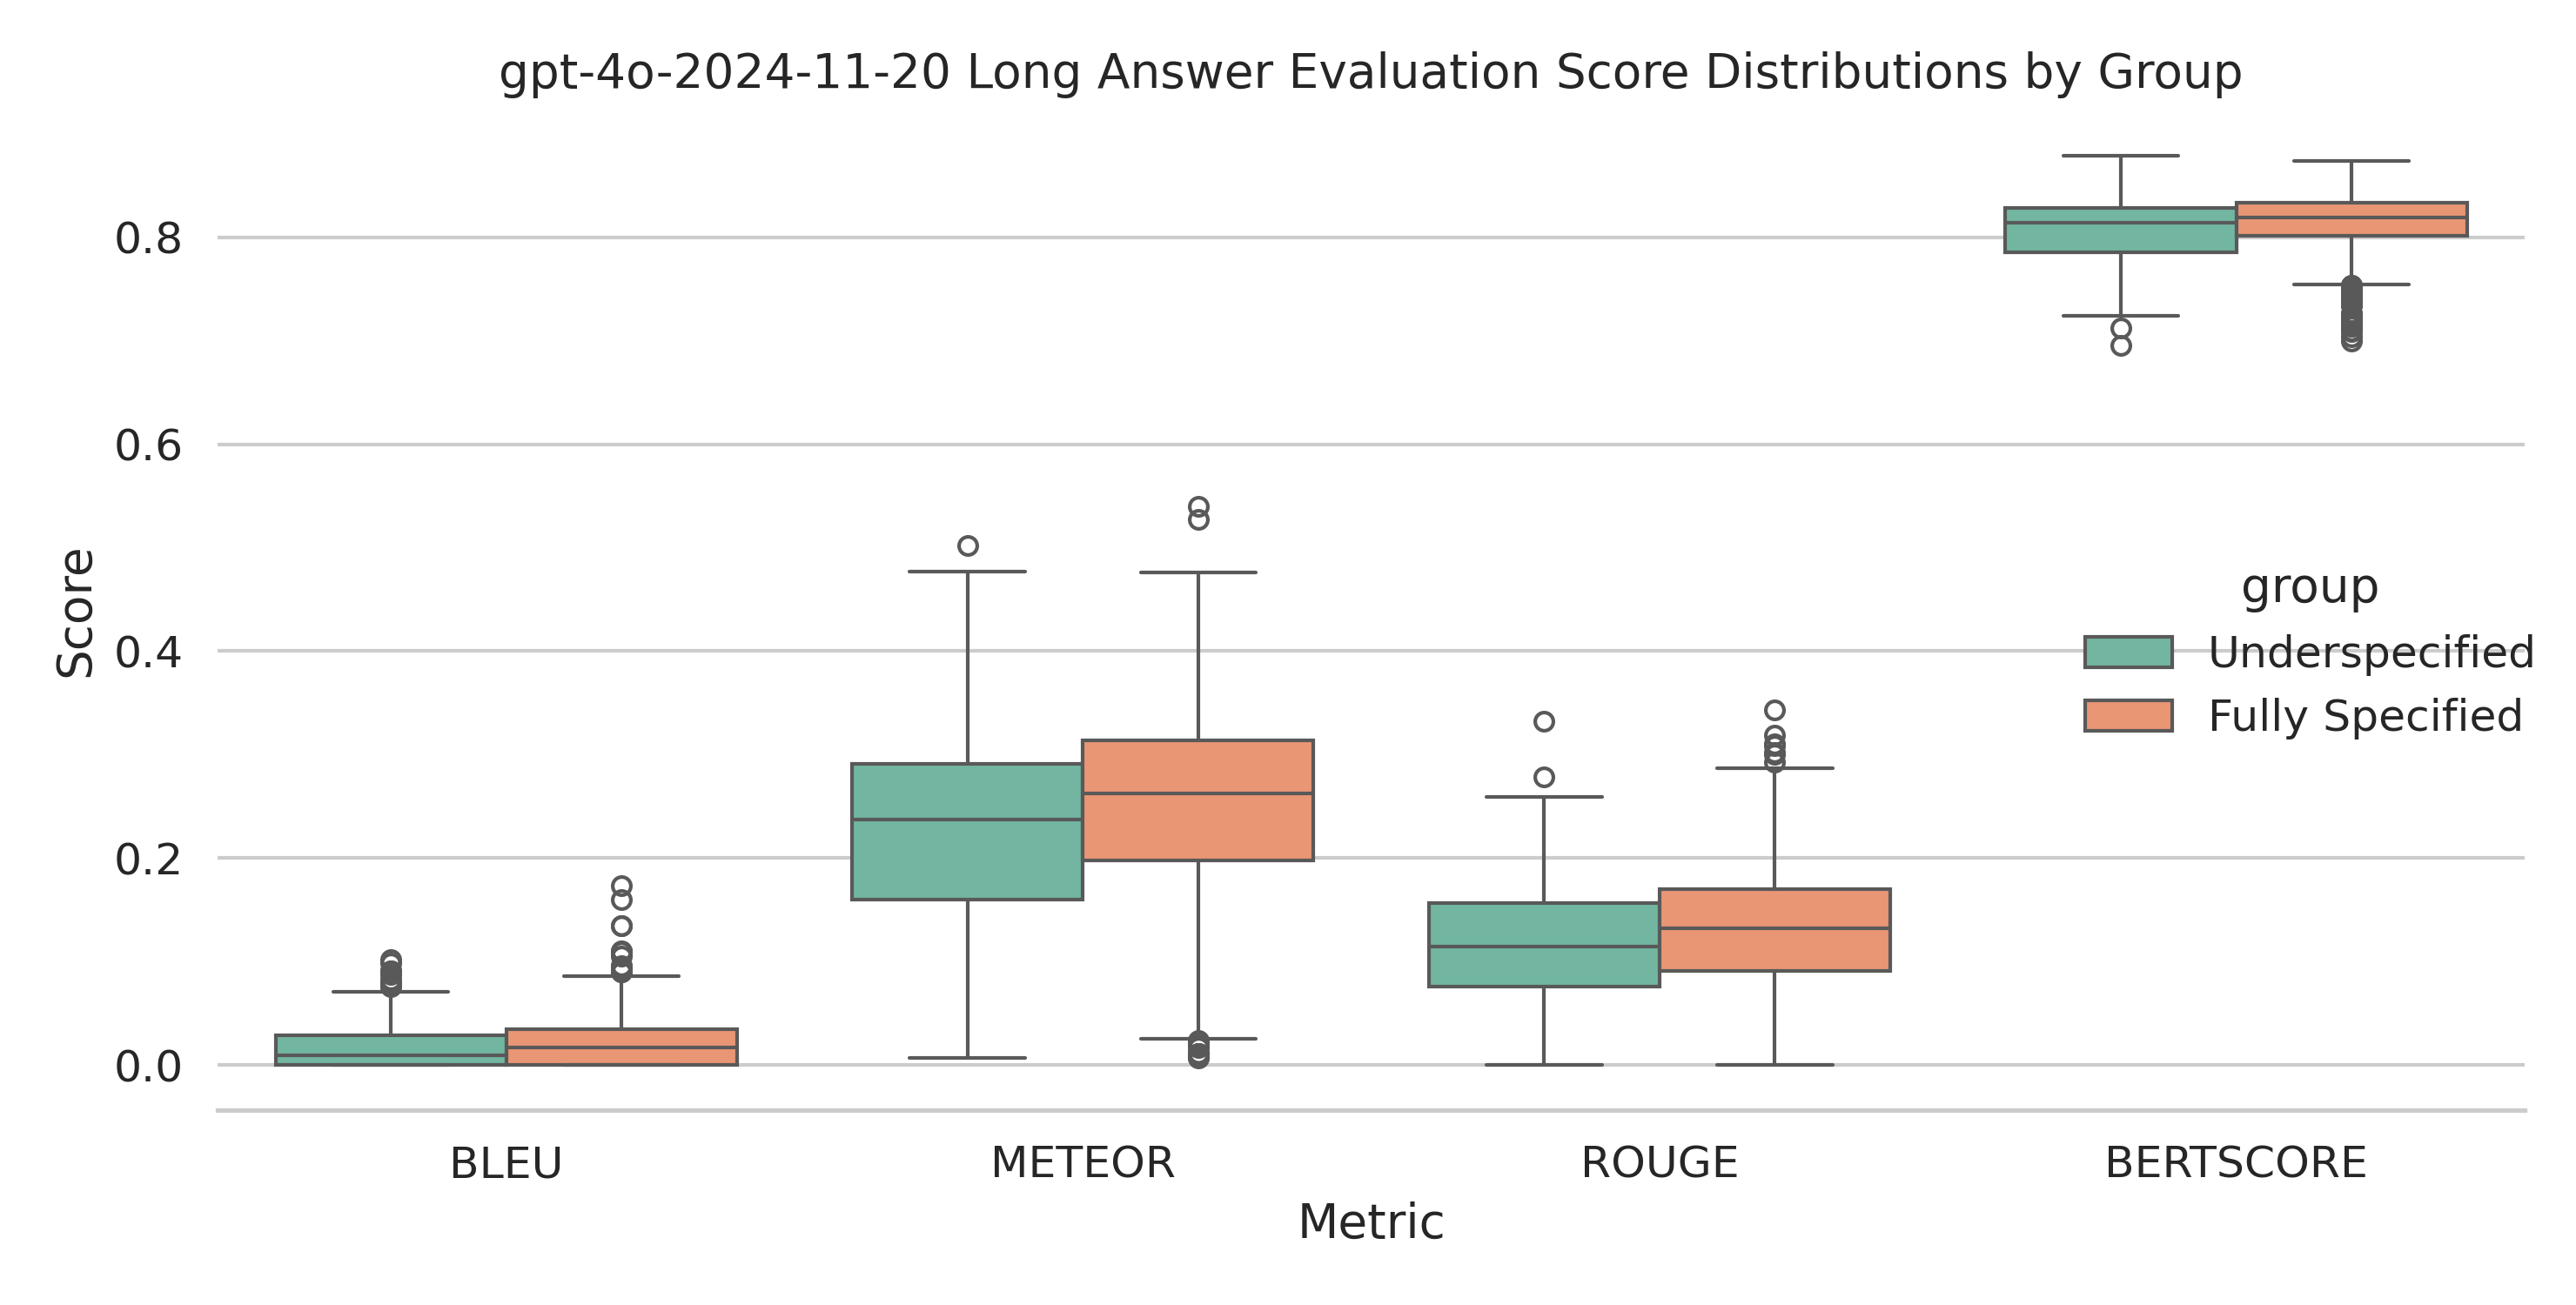

In [42]:
plot_metric_distributions(scores_UND, scores_FS, label_1="Underspecified", label_2="Fully Specified", filename="Google_NQ_metric_plot_gpt.png")

In [36]:
df = pd.read_json("GoogleNQ_UND_gpt_with_most_metrics.jsonl", lines=True)
df.to_csv('GoogleNQ_UND_gpt_with_most_metrics.csv')
df = pd.read_json("GoogleNQ_FS_gpt_with_most_metrics.jsonl", lines=True)
df.to_csv('GoogleNQ_FS_gpt_with_most_metrics.csv')

In [20]:
UND_full = load_dataset(
    "json",
    data_files="GoogleNQ_UND_gpt_with_most_metrics.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS_full = load_dataset(
    "json",
    data_files="GoogleNQ_FS_gpt_with_most_metrics.jsonl",
    split="train"
)

In [17]:
print(f'gpt_4o Google NQ UND qa average BLEU: {np.mean(UND_full["bleu"])}')
print(f'gpt_4o Google NQ FS qa average BLEU: {np.mean(FS_full["bleu"])}')
print(f'gpt_4o Google NQ UND qa average METEOR: {np.mean(UND_full["meteor"])}')
print(f'gpt_4o Google NQ FS qa average METEOR: {np.mean(FS_full["meteor"])}')
print(f'gpt_4o Google NQ UND qa average ROUGE: {np.mean(UND_full["rouge"])}')
print(f'gpt_4o Google NQ FS qa average ROUGE: {np.mean(FS_full["rouge"])}')
print(f'gpt_4o Google NQ UND qa average BERTSCORE: {np.mean(UND_full["bertscore"])}')
print(f'gpt_4o Google NQ FS qa average BERTSCORE: {np.mean(FS_full["bertscore"])}')

gpt_4o Google NQ UND qa average BLEU: 0.017525299078333334
gpt_4o Google NQ FS qa average BLEU: 0.022477235702857142
gpt_4o Google NQ UND qa average METEOR: 0.22081835096299998
gpt_4o Google NQ FS qa average METEOR: 0.24836756963785714
gpt_4o Google NQ UND qa average ROUGE: 0.11828894615199999
gpt_4o Google NQ FS qa average ROUGE: 0.13289474415799998
gpt_4o Google NQ UND qa average BERTSCORE: 0.805735661984
gpt_4o Google NQ FS qa average BERTSCORE: 0.8127452921012857


In [26]:
print(f'gpt_4o Google NQ UND qa EM SD: {np.std(UND_full["em"])}')
print(f'gpt_4o Google NQ FS qa EM SD: {np.std(FS_full["em"])}')
print(f'gpt_4o Google NQ UND qa F1 SD: {np.std(UND_full["f1"])}')
print(f'gpt_4o Google NQ FS qa F1 SD: {np.std(FS_full["f1"])}')

gpt_4o Google NQ UND qa EM SD: 0.36660605559646714
gpt_4o Google NQ FS qa EM SD: 0.45763143534097933
gpt_4o Google NQ UND qa F1 SD: 0.3619921807394281
gpt_4o Google NQ FS qa F1 SD: 0.40304546302789057


In [27]:
print(f'gpt_4o Google NQ UND qa BLEU SD: {np.std(UND_full["bleu"])}')
print(f'gpt_4o Google NQ FS qa BLEU SD: {np.std(FS_full["bleu"])}')
print(f'gpt_4o Google NQ UND qa METEOR SD: {np.std(UND_full["meteor"])}')
print(f'gpt_4o Google NQ FS qa METEOR SD: {np.std(FS_full["meteor"])}')
print(f'gpt_4o Google NQ UND qa ROUGE SD: {np.std(UND_full["rouge"])}')
print(f'gpt_4o Google NQ FS qa ROUGE SD: {np.std(FS_full["rouge"])}')
print(f'gpt_4o Google NQ UND qa BERTSCORE SD: {np.std(UND_full["bertscore"])}')
print(f'gpt_4o Google NQ FS qa BERTSCORE SD: {np.std(FS_full["bertscore"])}')

gpt_4o Google NQ UND qa BLEU SD: 0.02241016679961838
gpt_4o Google NQ FS qa BLEU SD: 0.025632874951334934
gpt_4o Google NQ UND qa METEOR SD: 0.10071303640479727
gpt_4o Google NQ FS qa METEOR SD: 0.09862493372857734
gpt_4o Google NQ UND qa ROUGE SD: 0.05681926832230225
gpt_4o Google NQ FS qa ROUGE SD: 0.05896790389475766
gpt_4o Google NQ UND qa BERTSCORE SD: 0.03268186224668049
gpt_4o Google NQ FS qa BERTSCORE SD: 0.03139368612886009


In [28]:
def welch_df(n1, sd1, n2, sd2):
    var1 = sd1**2
    var2 = sd2**2
    numerator = (var1/n1 + var2/n2)**2
    denominator = ((var1/n1)**2)/(n1 - 1) + ((var2/n2)**2)/(n2 - 1)
    return numerator / denominator

In [29]:
welch_df(300, np.std(UND_full["em"]), 700, np.std(FS_full["em"]))

698.4565580903487

In [30]:
welch_df(300, np.std(UND_full["f1"]), 700, np.std(FS_full["f1"]))

625.5775505065059